<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/02_MAB_movielens_egreedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Arm Bandits - Epsilon Greedy

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly.

#### Installation

In [ ]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-26 09:07:08--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4941 (4.8K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   4.83K  --.-KB/s    in 0s      

2021-02-26 09:07:08 (49.4 MB/s) - ‘./utils.py’ saved [4941/4941]



##### Imports

In [ ]:
from tqdm.notebook import trange
from typing import Dict, List, Text, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import zipfile

from utils import load_movielens_data
from utils import plot_accuracy, plot_actions, plot_cumsum, plot_regret

# Apply the default theme
sns.set_theme()

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.

In [ ]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-26 09:07:09--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  27.1MB/s    in 0.2s    

2021-02-26 09:07:09 (27.1 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



In [ ]:
!head ./'ml-100k/u.data'

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


#### Parameters -- Feel Free to Play Around

In [ ]:
RANK_K = 20 # @param {type:"integer"}
NUM_ACTIONS = 20 # @param {type:"integer"}

## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

> In every step, the batch of users will be selected randomly.

<br/>

**TASK** Add code into `_observe` and `step` methods, where

1. `_observe` will randomly generate sample (`batch_size`) of users 
1. `step` will return `reward` from provided batch of actions

Hint:

* You can use the `sample` method from `random` package
* `self._approx_ratings_matrix[i, j]` - `i` is the users index and `j` is the movie index

In [ ]:
class MovielensEnvironment(object):
  def __init__(
      self, 
      data_dir: Text,
      rank_k: int, 
      batch_size: int = 1,
      num_movies: int = 20
  ):
    """Initializes the MovieLens Bandit environment.

    Args:
      data_dir: (string) Directory where the data lies (in text form).
          The file is a csv with rows containing:
          user id | item id | rating | timestamp
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)
    # Currently generated sample of users
    self._current_users = np.zeros(batch_size)
    # Previously generated sample of users
    self._previous_users = np.zeros(batch_size)

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)
    
    self.reset()

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def best_action(self) -> int:
    return np.argmax(np.sum(env._data_matrix, axis=0))

  @property
  def n_actions(self) -> int:
    return self._data_matrix.shape[1]

  def reset(self):
    return self._observe()

  def _observe(self) -> np.ndarray:
    """Returns the u vectors of a random sample of users."""
    # YOUR CODE GOES HERE
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    # END OF YOUR CODE
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def step(self, action: List[int]) -> Tuple[int, float]:
    """Computes the reward for the input actions."""
    # YOUR CODE GOES HERE
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    # END OF YOUR CODE

    # Generate a new users
    self._observe()
    return np.array(rewards)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

Now we are equipped to initialize our environment.

In [ ]:
env = MovielensEnvironment(
    './ml-100k/u.data', rank_k=RANK_K, batch_size=1, num_movies=NUM_ACTIONS)

Below we can check what this environment produces.

In [39]:
env.reset()

action = np.zeros(batch_size, dtype=np.int32) # Create action=0 - first movie
reward = env.step(action)

print(f'For users={env._previous_users}, we selected action={action} (optimal={env.compute_optimal_action()})')
print(f'For users={env._previous_users}, we received reward={reward} (optimal={env.compute_optimal_reward()})')

For users=[61], we selected action=[0 0] (optimal=[14])
For users=[61], we received reward=[1.08995049e-14] (optimal=[4.])


## Policy

The $\epsilon-greedy$ algorithm takes the best action most of the time, but does random exploration occasionally (with probability $\epsilon$). The action value is estimated according to the experience by averaging the rewards associated with the target action that we have observed so far

$$
\hat{Q}_{t}(a) = \frac{1}{N_{t}(a)}\sum_{\tau=1}^{t}r_{\tau, a}
$$

where $N_{t}(a)$ is how many times the action a has been selected so far.

According to the $\epsilon-greedy$ algorithm, with a small probability $\epsilon$ we take a random action, but otherwise (which should be the most of the time, probability $1 - \epsilon$) we pick the best action that we have learned so far

$$
\hat{a}_{t}^{\ast} = argmax \hat{Q}_{t}(a).
$$

<br/>

**TASK**: Fill in a missing code for generating batch of actions, where

* with probability $1 - \epsilon$ will be selected current best action,
* with probability $\epsilon$ will be the action selected randomly.

In [ ]:
class EpsilonGreedyPolicy(object):
  def __init__(self, epsilon: float, values: List[float], batch_size: int = 1):
    self._epsilon = epsilon
    self._Q = values

    self._batch_size = batch_size

  def action(self) -> int:
    val_max = max(self._Q)

    ret = []
    # YOUR CODE GOES HERE
    for rnd in np.random.rand(self._batch_size):
      if rnd > self._epsilon:
        ret.append(np.random.choice(
            [i for i, val in enumerate(self._Q) if val == val_max]))
      else:
        ret.append(np.random.randint(len(self._Q)))
    # END OF YOUR CODE
    
    return ret

Below we can check what this policy produces.

In [ ]:
p = EpsilonGreedyPolicy(epsilon=0.3, values=[1, 2, 3], batch_size=10)
print(f'E-Greedy - action:{p.action()}')

E-Greedy - action:[2, 0, 2, 2, 1, 2, 0, 0, 2, 2]


## Agent

As was mentioned above, the $\epsilon-greedy$ algorithm takes the best action most of the time, but does random exploration occasionally. The action value is estimated according to the past experience by averaging the rewards associated with the target action a that we have observed so far (up to the current time step $t$)

$$
\hat{Q}_{t}(a) = \frac{1}{N_{t}(a)}\sum_{\tau=1}^{t}r_{\tau, a}
$$

where $N_{t}(a)$ is how many times the action a has been selected so far.

<br/>

**TASK**: Fill in a missing code for updating the action value estimations.
1. initialize `Q` and `N` in `reset` method
1. update $N_{t}(a)$
1. update $\hat{Q}_{t}(a)$ (`self._values`) -> $\frac{n - 1}{n} * Q + \frac{1}{n} * r$

In [ ]:
class EpsilonGreedyAgent(object):
  
  def __init__(self, n: int, epsilon: float = 0.1, batch_size: int = 1):
    self._epsilon = epsilon
    self._n = n
    self._batch_size = batch_size

    self.reset()

    self.policy = EpsilonGreedyPolicy(
        self._epsilon, self._values, batch_size=batch_size)

  def reset(self):
    self._counts = [0] * self._n # YOUR CODE HERE # N_t
    self._values = [0.0] * self._n # YOUR CODE HERE # Q_t

  def train(self, experience: Dict[str, float]):
    """Update policy parameters.

    Args:
      experience: dictionary with a single action and reward
    """
    action = experience['action']
    reward = experience['reward']
    
    # YOUR CODE GOES HERE
    self._counts[action] += 1

    value = self._values[action]
    n = self._counts[action]

    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward
    # END OF YOUR CODE

Below we can check how the training affects rewards estimation.

In [ ]:
ag = EpsilonGreedyAgent(3)

experience = {'action': 2, 'reward': 1}
ag.train(experience)
print(f'Q={ag._values}')

experience = {'action': 2, 'reward': 0}
ag.train(experience)
print(f'Q={ag._values}')

Q=[0.0, 0.0, 1.0]
Q=[0.0, 0.0, 0.5]


## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data.

In [ ]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {
      'trial': 0, 
      'action': -1, 
      'observation': 0, 
      'reward': 0,
      'regret': -1
  }

  for i in range(trials):
    experience['trial'] = i + 1
    actions = agent.policy.action()
    rewards = environment.step(actions)
    optimal_rewards = environment.compute_optimal_reward()

    for action, reward, optimal_reward in zip(actions, rewards, optimal_rewards):
      experience['action'] = action
      experience['reward'] = reward
      experience['regret'] = optimal_reward - reward

      agent.train(experience)

      #df_trajectory = df_trajectory.append(experience, ignore_index=True)
      trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

Down below is the code for creating all necessary instances. We have here a few parameters we can play with. `num_iterations` specifies how many times we run the trainer loop, `batch_size` defines how many actions are generated through one step and `epsilon` defines the probability of randomly selected action.

In [ ]:
batch_size =   32 # @param {type:"integer"}
epsilon = 0.1 # @param {type: "number"}
num_iterations =   150 # @param {type:"integer"}

environment = MovielensEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K, 
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS)
step = environment.reset()

agent = EpsilonGreedyAgent(
    environment.n_actions, 
    epsilon=epsilon, 
    batch_size=environment.batch_size)
experience = {'action': [-1], 'reward': [0]}

df_trajectory = run(environment, agent, trials=num_iterations)

print(f'\Q={agent._values}')
print(f'N={agent._counts}')
print(
  f'best action={np.argmax(agent._values)} '
  f'(environment best_action={environment.best_action})'
)

\Q=[2.372456223379092, 0.5384615384615329, 0.11999999999999868, 1.159999999999987, 0.9999999999999951, 0.07407407407407521, 2.122807017543856, 0.3999999999999969, 1.7037037037037128, 0.41935483870967943, 0.8076923076922906, 1.6785714285714075, 0.6800000000000037, 1.2000000000000106, 1.111111111111128, 1.6216731517334627e-15, 0.3333333333333259, 0.13043478260869543, 0.7714285714285766, 0.13043478260869784]
N=[4226, 26, 25, 50, 20, 27, 57, 25, 27, 31, 26, 56, 25, 20, 27, 24, 27, 23, 35, 23]
best action=0 (environment best_action=0)


Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [ ]:
params = {
  'algorithm': 'E-Greedy',
  'best_action': environment.best_action
}

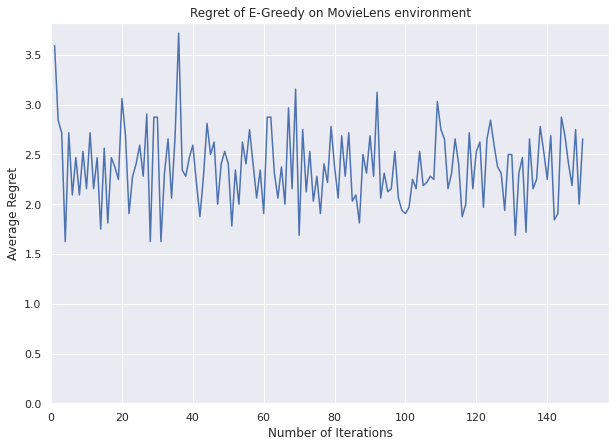

In [ ]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

Let's see the cumulative reward of the actions during the experiment.

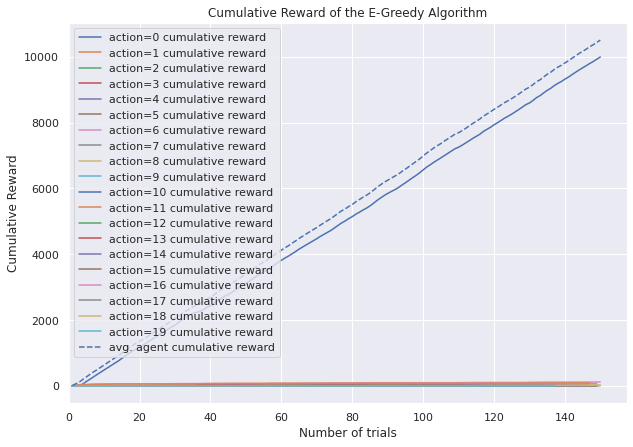

In [ ]:
plot_cumsum(df_trajectory.copy(), params, show_actions=True)

#### Multiple runs

In [ ]:
def experiment(epsilons: List[float], epochs: int = 1, trials: int = 10, batch_size: int = 1):
  trajectories = []
  
  environment = MovielensEnvironment(
      './ml-100k/u.data', 
      rank_k=RANK_K, 
      batch_size=batch_size, 
      num_movies=NUM_ACTIONS)
  params = {'best_action': environment.best_action}
  
  for epsilon in epsilons:
    for epoch in trange(epochs):
      step = environment.reset()
      agent = EpsilonGreedyAgent(
          environment.n_actions, 
          epsilon=epsilon, 
          batch_size=environment.batch_size)
      
      df = run(environment, agent, trials=trials)
      df['epoch'] = epoch + 1
      df['epsilon'] = epsilon

      trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

Compared to a single run, we have one extra parameter. `epochs` controls the number of independent runs of the training loop. We can even test multiple `epsilons`.

In [ ]:
batch_size =   256 # @param {type:"integer"}
epochs =  25# @param {type: "integer"}
num_iterations =   150 # @param {type:"integer"}

df_trajectory, params = experiment(
    epsilons=[0.1], 
    epochs=epochs, 
    trials=num_iterations, 
    batch_size=batch_size)

Now let's see the average results after running multiple runs. The resulting regret plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [ ]:
params['algorithm'] = 'E-Greedy'

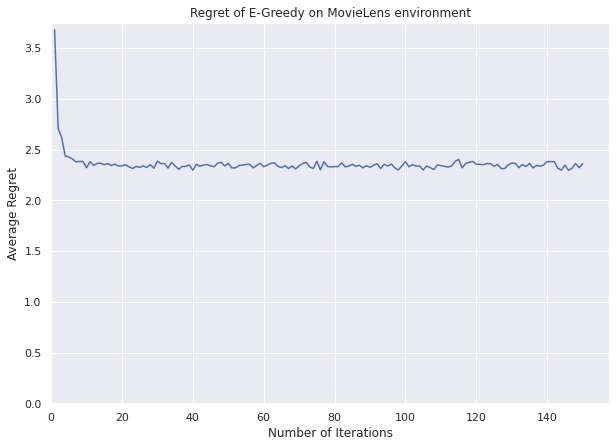

In [ ]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

On the other graph, we can see the accuracy of the environment's best action.





























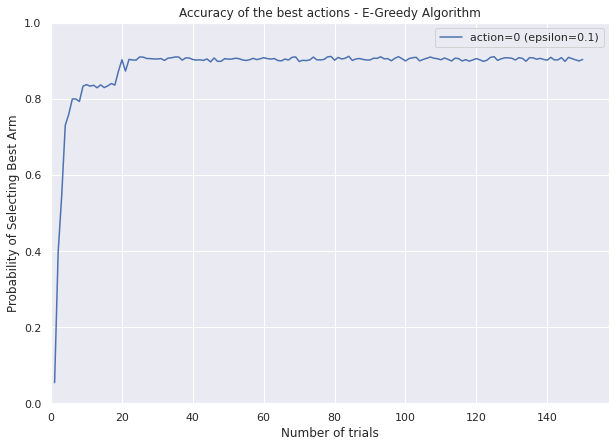

In [ ]:
plot_accuracy(df_trajectory, params)

Let's see the cumulative reward of the actions during the experiment.

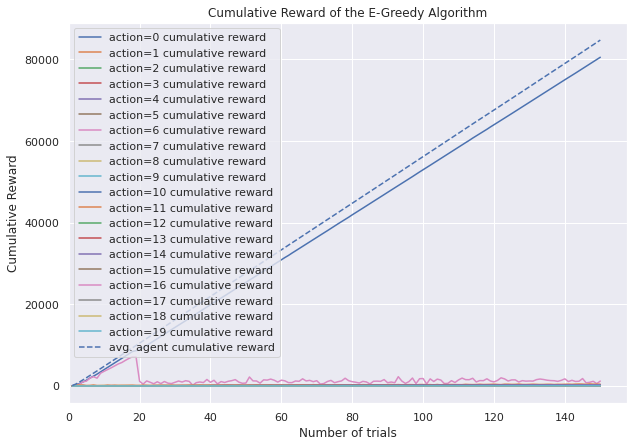

In [ ]:
plot_cumsum(df_trajectory[df_trajectory.epsilon == 0.1], params, show_actions=True)

Let's see the selection's rate of the actions during the experiment.

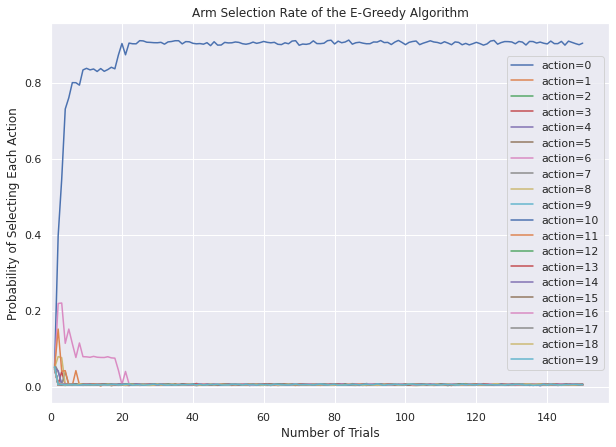

In [ ]:
plot_actions(df_trajectory[df_trajectory.epsilon == 0.1], params)